In [14]:
# %load ../helpers/header.py
# load ENV path to project from .profile 
import os, sys
PROJECT_ROOT_DIR=os.environ.get('ML_PATH')
sys.path.append(os.path.join(PROJECT_ROOT_DIR, "helpers")) # add helper modules to path

# MPL 
import MPL_header #load common MPL imports (from helpers)
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib widget 

# NP, constant seed, PD 
import numpy as np
np.random.seed(12345)
import pandas as pd

# Where to save the figures
SUB_DIR = "training"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig", SUB_DIR)
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "fig")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [15]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

Saving figure generated_data_plot


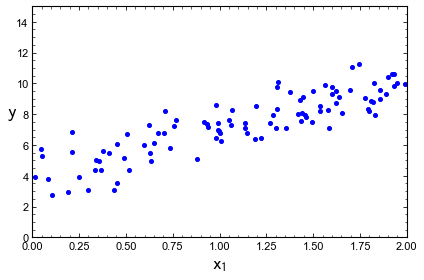

In [16]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [19]:
X_b = np.c_[np.ones((100, 1)), X]

array([[1.        , 1.85923219],
       [1.        , 0.63275111],
       [1.        , 0.36783762],
       [1.        , 0.40912056],
       [1.        , 1.13545006],
       [1.        , 1.19108941],
       [1.        , 1.92902904],
       [1.        , 1.30635419],
       [1.        , 1.49781328],
       [1.        , 1.30713974],
       [1.        , 1.49542962],
       [1.        , 1.92261347],
       [1.        , 0.0167766 ],
       [1.        , 0.21288875],
       [1.        , 0.59740743],
       [1.        , 1.31282237],
       [1.        , 1.61962511],
       [1.        , 1.74435183],
       [1.        , 1.92929519],
       [1.        , 1.44737069],
       [1.        , 1.28495066],
       [1.        , 1.43490724],
       [1.        , 0.93519801],
       [1.        , 0.65116936],
       [1.        , 0.87928921],
       [1.        , 1.45937817],
       [1.        , 1.98802917],
       [1.        , 1.35374742],
       [1.        , 1.58164504],
       [1.        , 0.34182852],
       [1.